# SMAM Workshop June 2024 mumott tutorial

Mads Carlsen - 11.06.2024

## Outline

1. Installing and running mumott
2. Accessing the data and basic plotting
3. The projector
4. Alignment
5. Basic reconstructions
6. Basic plots of reconstruction results


### 1 Installing and running mumott

If you have made it this far, you are already running python in a Jupyter Notebook environment. Good job!
Next thing is to try to import mumott. Give it a go!

In [28]:
import mumott
print(mumott.__version__)

2.1


In [29]:
import numpy as np
import matplotlib.pyplot as plt

### 2 Accessing the data and basic plotting

`'tutorial_frog.h5'` contains the azimuthally-regrouped intensities in the q-range 0.005-0.007 1/Å.   
Normally, we make sure to include all the geometry information in the files after an experiment.  
But if that information is wrong or if you are the one running the experiment now (good luck :-\\),  
then you need to know how to figure that information out yourself.  


Therefore, I have removed all the geometry information from the file, so we can figure it out together!  
  
First, we load the data file:

In [30]:
data_container = mumott.DataContainer('../frogbone/dataset_qbin_0000.h5', nonfinite_replacement_value = 0)
print(data_container.data.shape)

INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.
(240, 73, 100, 8)


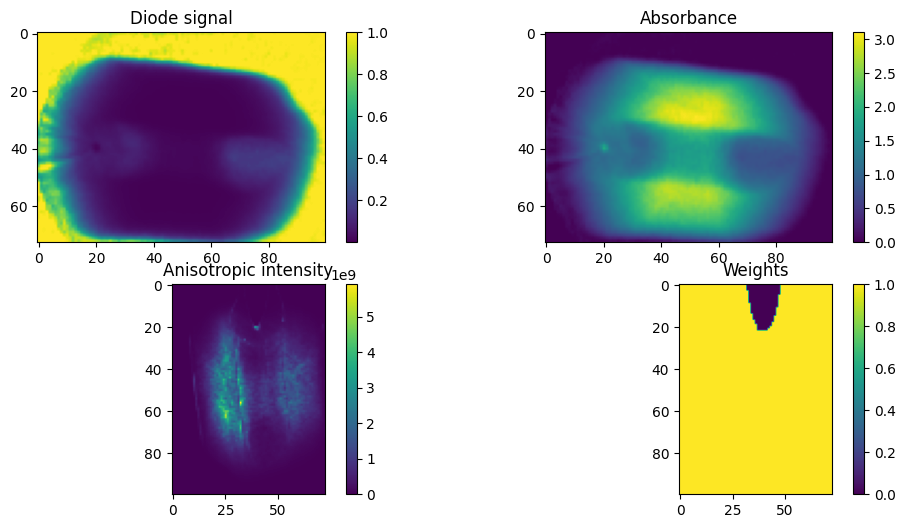

In [31]:
projection_index = 60

fig, ax = plt.subplots(2,2, figsize = (12, 6))
img = ax[0,0].imshow(data_container.diode[projection_index,:, :])
fig.colorbar(img)
ax[0,0].set_title('Diode signal')

img = ax[0,1].imshow(-np.log10(data_container.diode[projection_index, :, :]))
fig.colorbar(img)
ax[0,1].set_title('Absorbance')


img = ax[1,0].imshow(np.sum(data_container.data[projection_index, :, :]**2, axis = -1).T)
fig.colorbar(img)
ax[1,0].set_title('Anisotropic intensity')

img = ax[1,1].imshow(np.min(data_container.weights[projection_index, :, :], axis = -1).T)
fig.colorbar(img)
ax[1,1].set_title('Weights')

plt.show()

In [32]:
data_container.diode.shape

(240, 73, 100)

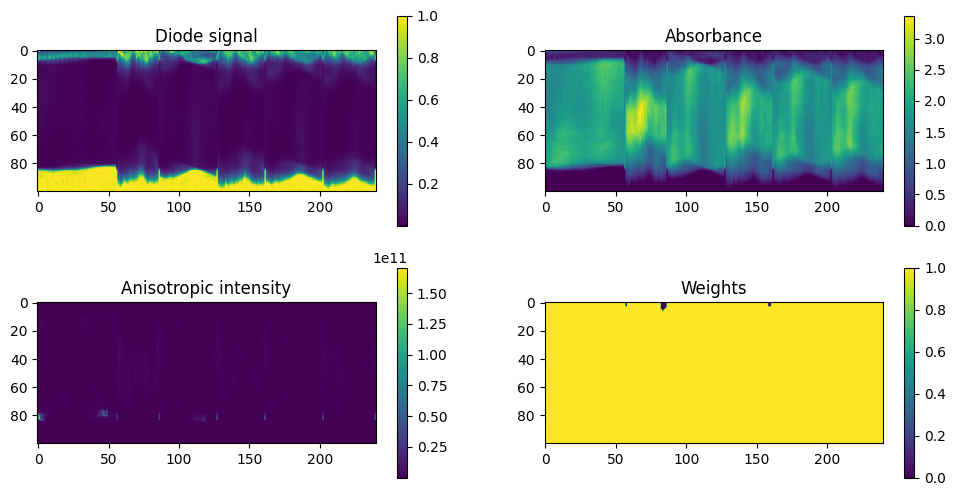

In [33]:
raster_index = 30

fig, ax = plt.subplots(2,2, figsize = (12, 6))
img = ax[0,0].imshow(data_container.diode[:, raster_index, :].T)
fig.colorbar(img)
ax[0,0].set_title('Diode signal')

img = ax[0,1].imshow(-np.log10(data_container.diode[:, raster_index, :].T))
fig.colorbar(img)
ax[0,1].set_title('Absorbance')


img = ax[1,0].imshow(np.sum(data_container.data[:, raster_index, :, :]**2, axis = -1).T)
fig.colorbar(img)
ax[1,0].set_title('Anisotropic intensity')

img = ax[1,1].imshow(np.min(data_container.weights[:, raster_index, :, :], axis = -1).T)
fig.colorbar(img)
ax[1,1].set_title('Weights')

plt.show()

In [34]:
data_container.data.shape

(240, 73, 100, 8)

/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/1954644874.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


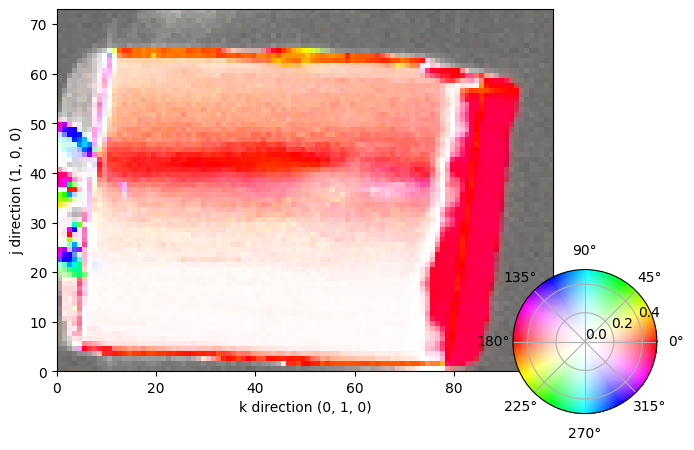

In [35]:
from mumott_plotting.data_plots import make_colorful_plot, make_color_wheel

max_doo = 0.5
max_intens = 300

fig, ax = plt.subplots()
img, rgb = make_colorful_plot(data_container.data[0, ...], data_container.geometry, ax, max_intens = max_intens, max_doo = max_doo)
ax = fig.add_subplot([0.8, 0.03, 0.3, 0.3], polar = True)
make_color_wheel(ax, max_doo)
fig.show()

Did you read the messages when we loaded the data?  
Mumott is telling you that it didn't find any geometry information in the file and is assuming  
the default mumott geometry. This default is **not** the cSAXS geometry, that we use in the papers. Let's have a look: 

In [36]:
print(data_container.geometry)

--------------------------------------------------------------------------
                                 Geometry                                 
--------------------------------------------------------------------------
hash_rotations     : e61813
hash_j_offsets     : 25a48a
hash_k_offsets     : 30ee4a
p_direction_0      : [0. 0. 1.]
j_direction_0      : [1. 0. 0.]
k_direction_0      : [0. 1. 0.]
hash_inner_angles  : a82439
hash_outer_angles  : 8460c7
hash_inner_axes    : eeafe5
hash_outer_axes    : cb1331
detector_direction_origin : [0. 1. 0.]
detector_direction_positive_90 : [1. 0. 0.]
two_theta          : [0.]°
projection_shape   : [ 73 100]
volume_shape       : [65 82 65]
detector_angles    : [0.196 ... 2.945]
full_circle_covered : False
--------------------------------------------------------------------------


Some of these numbers are obviously wrong. Luckily, you wrote everything down in the  
logbook! Mumott let's you change these numbers on the fly, but ofc. it would be better  
if you put them in the data file. That way the next guy doesn't have to worry about it.  
  
Fix up the numbers and check that the colorful plot looks right afterwards.

In [37]:
data_container.geometry.p_direction_0 = [0, 0, 1]
data_container.geometry.k_direction_0 = [0, 1, 0]
data_container.geometry.j_direction_0 = [1, 0, 0]
data_container.geometry.detector_direction_origin = [0, 1, 0]
data_container.geometry.detector_direction_positive_90 = [1, 0, 0]

### 3 The projector 

Now that the geometry is good, we can define a projector and start doing tomography!

In [38]:
from mumott.methods.projectors import SAXSProjector
projector = SAXSProjector(data_container.geometry)

The easiest way to check that everything is good is to compute the backprojection of the absorbance:

(65, 82, 65, 1)


/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/2533745945.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


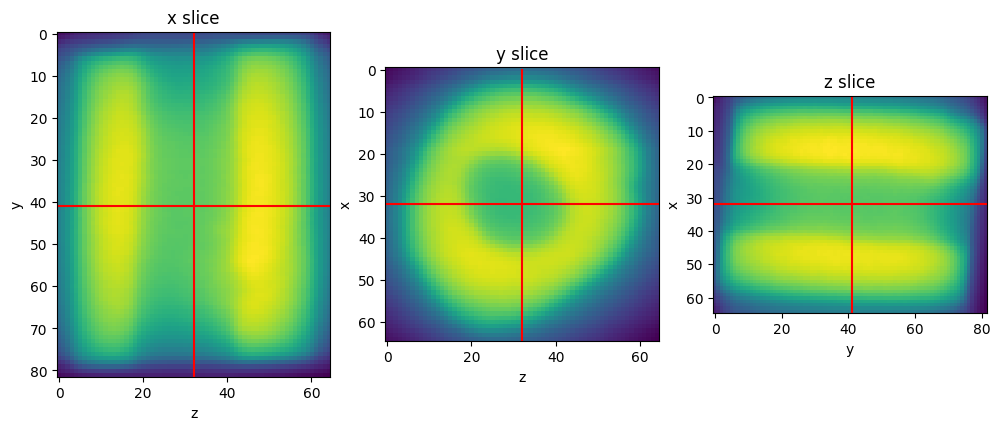

In [39]:
from mumott_plotting.tomogram_plots import plot_scalar_slices

absorbance = -np.log10(data_container.diode+1e-10)
back_projection = projector.adjoint(absorbance[:,:,:,np.newaxis])
print(back_projection.shape)

fig, axs = plot_scalar_slices(back_projection[...,0])
fig.show()

(240, 8, 3, 3)


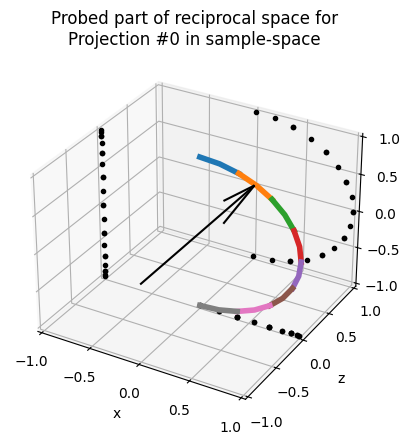

In [40]:
from mumott_plotting.geometry_plots import make_scattering_vector_plot
ax = make_scattering_vector_plot(data_container.geometry, 0)
plt.show()

Turns out, we are only half way with figuring out the geometry. We still need to specify how the sample  
rotates from projection to projection. There are two ways to do this:

1. Give a rotation matrix for each projection. (Mumott uses the active rotation of the sample)
2. Give two pairs of angles and rotation axes corresponding to the inner and outer rotation stages.

In this file only the angles are given, not the axes, so again, the default is assumed.

The information about rotations is stored inside each `ProjectionTuple` in a list inside the geometry object.
Let's loon at one of these:

--------------------------------------------------------------------------
                              GeometryTuple                               
--------------------------------------------------------------------------
rotation           : [1. 0. 0.], [0.00000e+00 1.00000e+00 9.92105e-16], [ 0.00000e+00 -9.92105e-16  1.00000e+00]
j_offset           : -3.0
k_offset           : 5.0
inner_angle        : 0.0
outer_angle        : -9.921048172113442e-16
inner_axis         : 0.0, 0.0, -1.0
outer_axis         : 1.0, 0.0, 0.0
Hash               : db017d
--------------------------------------------------------------------------


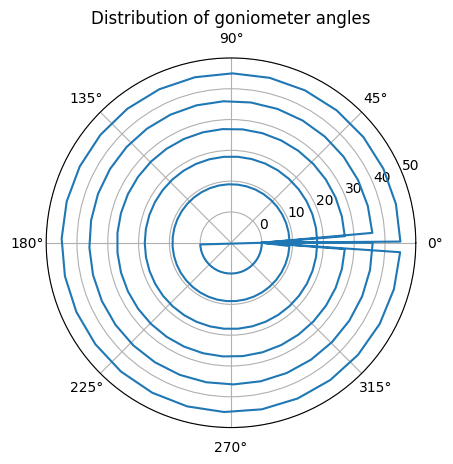

In [41]:
print(data_container.geometry[0])

ax = plt.subplot(1,1,1, polar = True)
ax.plot([gt.inner_angle for gt in data_container.geometry],
        [180 / np.pi * gt.outer_angle for gt in data_container.geometry],)
ax.set_ylim(-10, 50)
ax.set_title('Distribution of goniometer angles')
plt.show()

In [42]:
data_container.geometry.inner_axes = [0, 1, 0]
data_container.geometry.outer_axes = [1, 0, 0]
data_container.geometry.volume_shape = [65, 80, 65]

Now for the real test, let's run a filtered back-projection

In [43]:
from mumott.pipelines import run_fbp
fbp_results = run_fbp(data_container)

/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/2959443011.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


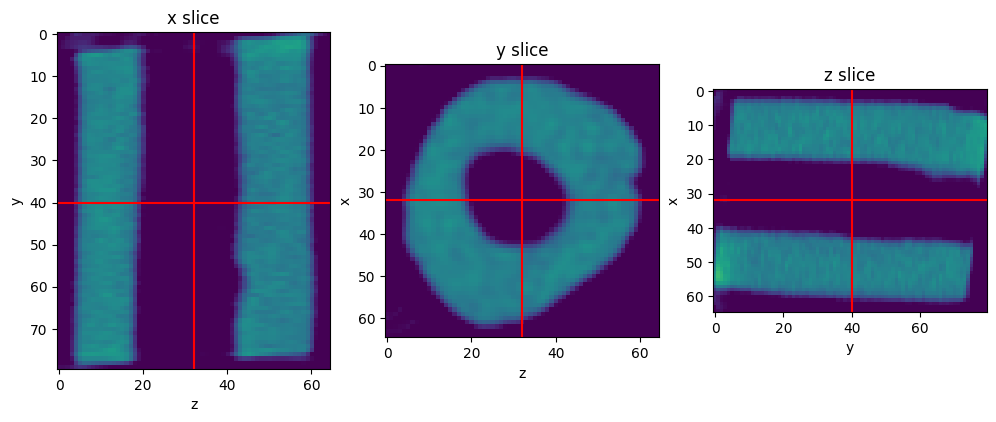

In [44]:
fbp = fbp_results['result']['x'][...,0]
fig, axs = plot_scalar_slices(fbp, imshow_args = {'vmin':0, 'vmax':0.1})
fig.show()


Not too bad, but we still need to do the alignment.

### 4 Alignment

Due to misalignments, the sample is shifting back and forth a little bit. Thsi will cause problems for  
the reconstructions is we don't fix it. That is what alignment is all about.

When everything else is done right (fingers crossed) the built in alignment should just work.

100%|██████████| 20/20 [00:09<00:00,  2.17it/s]


/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/4257662916.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


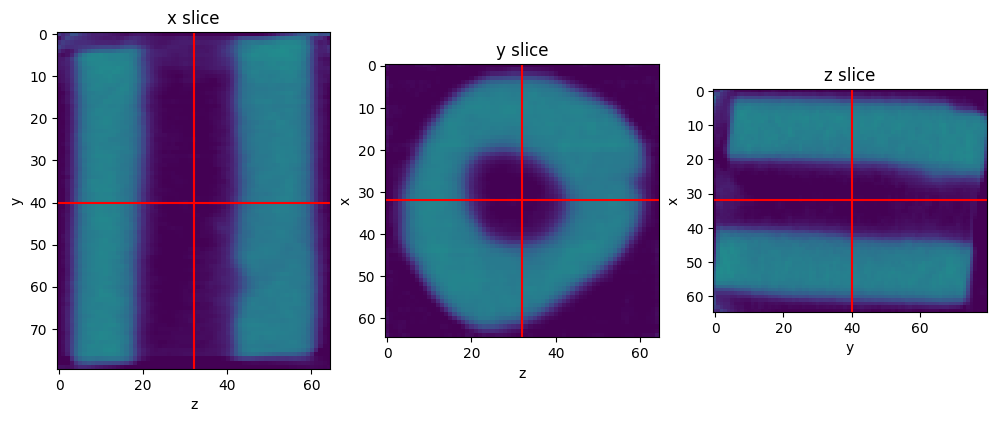

In [45]:
from mumott.pipelines import run_sirt
sirt_results = run_sirt(data_container, use_gpu = False)
fig, axs = plot_scalar_slices(sirt_results['result']['x'], imshow_args = {'vmin':0, 'vmax':0.1})
fig.show()

In [46]:
from mumott.pipelines.optical_flow_alignment import run_optical_flow_alignment
from mumott.pipelines import run_phase_matching_alignment


#### Semi-manual alignment.

The algotithmic alignment often has some problems. I recommend a half-manual approach:

First, pick a number for how much the axis of the first rotation is off center:

/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/162666240.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


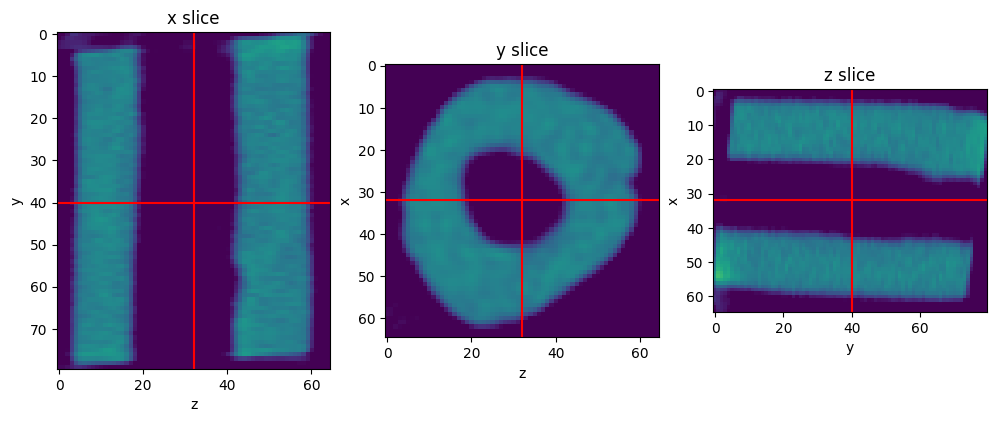

In [47]:
first_rotation_off_center = -2.5
data_container.geometry.j_offsets = [first_rotation_off_center]*len(data_container.geometry.j_offsets)

fbp_results = run_fbp(data_container)
fbp = fbp_results['result']['x'][...,0]
fig, axs = plot_scalar_slices(fbp, imshow_args = {'vmin':0, 'vmax':0.1})
fig.show()


Now the projection of the FBP reconstruction should match the measured data.

/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/2173610110.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


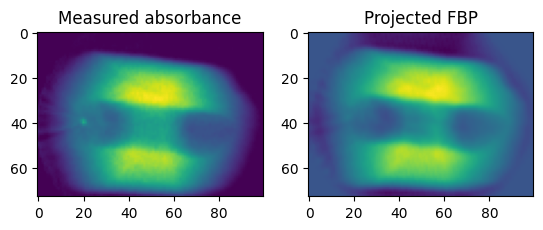

In [48]:
p_index = 60

fbp_projected = projector.forward(fbp[..., np.newaxis])[...,0]

fig, axs = plt.subplots(1,2)
axs[0].imshow(-np.log10(data_container.diode[p_index]))
axs[0].set_title('Measured absorbance')
axs[1].imshow(fbp_projected[p_index])
axs[1].set_title('Projected FBP')
fig.show()

If it does, we loop over the projections and compute the offsets and assign them.

/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/72715912.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


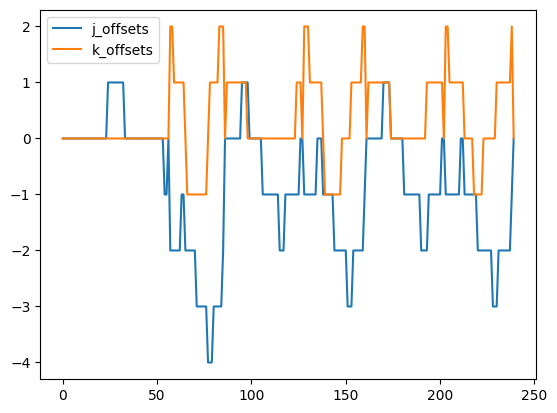

In [49]:
from skimage.registration import phase_cross_correlation as phase_xcorr

j_offsets = []
k_offsets = []

for p_index in range(len(data_container.geometry)):
    
    reference_image = fbp_projected[p_index]
    moving_image = -np.log10(data_container.diode[p_index])
    mask = data_container.weights[p_index,...,0] < 0.5
    offset_jk = phase_xcorr(moving_image, reference_image, reference_mask = ~mask)[0]
    j_offsets.append(-offset_jk[0])
    k_offsets.append(-offset_jk[1])
        
fig, ax = plt.subplots()
ax.plot(j_offsets)
ax.plot(k_offsets)
ax.legend(['j_offsets', 'k_offsets'])
fig.show()

data_container.geometry.j_offsets = np.array(data_container.geometry.j_offsets) + np.array(j_offsets)
data_container.geometry.k_offsets = np.array(data_container.geometry.k_offsets) + np.array(k_offsets)


To test the results, we see if the sirt reconstruction has improved.

100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/4257662916.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


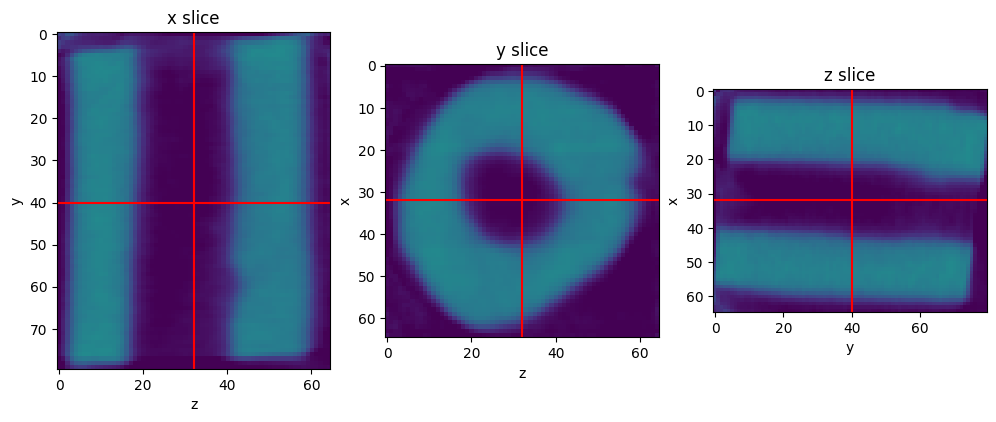

In [50]:
from mumott.pipelines import run_sirt
sirt_results = run_sirt(data_container, use_gpu = False)
fig, axs = plot_scalar_slices(sirt_results['result']['x'], imshow_args = {'vmin':0, 'vmax':0.1})
fig.show()

### 5 Basic reconstructions

Everything we've done until not should normally not be necessary.

These geometry determination things have to be done once, when we commision the experiment at a new beamline or  
whenever something changes at that beamline. The geometry information can then be stored in the data files, and  
will be loaded automatically. It is however strongly recommended to look at some of these plots to see if  
everything is defined correctly. Some geometry errors will give good-looking reconstruction, that are however wrong in some way.

Alignment may or ma not be done before the files are created.

For normal users, the mumott-reconstruction workflow starts here.

The optimization problem of TT looks something like:

$c^* = \underset{c}{argmin}\left[\left\lVert 
I - B P c \right\rVert_{a}+ \mu \left\lVert Dc 
\right\rVert_{b}\right]$ 

Lets have a look at the differnt objects:

$\vec{c}$ are the coefficients we are trying to find.

$\matrix{I}$ is the measured data.

$\matrix{P}$ is the proejction operator, that we have already used in the previous steps. 

$\matrix{B}$ is the basis-function expansion in reciprocal space. We define it as:


In [51]:
from mumott.methods.basis_sets import SphericalHarmonics, NearestNeighbor, GaussianKernels
from mumott.methods.utilities.grids_on_the_sphere import football

# print(SphericalHarmonics.__doc__)
basis_set = SphericalHarmonics(ell_max = 8)

/Users/lfbarba/GitHub/smartTT/.venv/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/3192943503.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


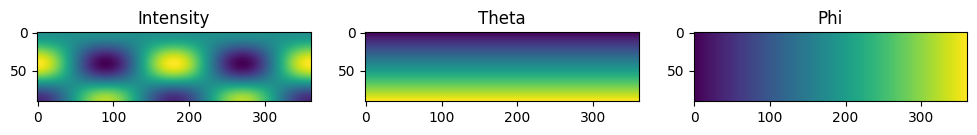

In [52]:
basis_function_index = 12

coefficients = np.zeros(len(basis_set))
coefficients[basis_function_index] = 1

map_intensity, map_theta, map_phi = basis_set.generate_map(coefficients, map_half_sphere = True, resolution_in_degrees = 1)

fig, axs = plt.subplots(1,3, figsize = (12,4))
axs[0].imshow(map_intensity)
axs[0].set_title('Intensity')
axs[1].imshow(map_theta)
axs[1].set_title('Theta')
axs[2].imshow(map_phi)
axs[2].set_title('Phi')
fig.show()

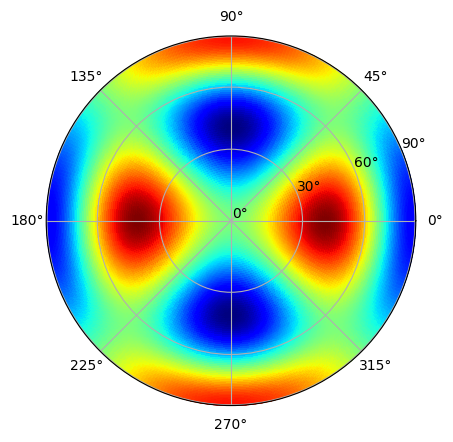

In [53]:
from mumott_plotting.map_plots import plot_on_polefigure, make_scattering_vector_plot

ax = plt.subplot(1,1,1, polar = True)
plot_on_polefigure(ax, map_intensity, map_theta, map_phi)
plt.show()

/Users/lfbarba/GitHub/smartTT/.venv/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


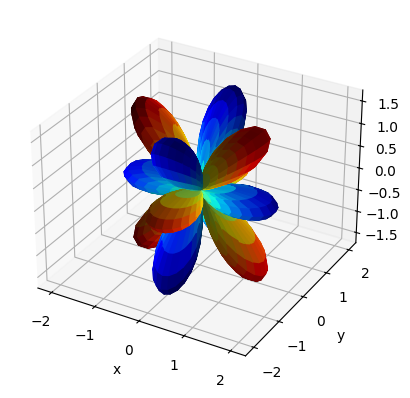

In [54]:
map_intensity, map_theta, map_phi = basis_set.generate_map(coefficients, map_half_sphere = False, resolution_in_degrees = 5)

ax = plt.subplot(1,1,1, projection='3d')
surface = make_scattering_vector_plot(ax, map_intensity, map_theta, map_phi)
plt.show()

$\left\lVert \cdot \right\rVert_{a}$ is a vector norm used to define the fideliy term of the optimization problem.  
mumott calls it the `LossFunction`. Before we can define it however, we need to define a `ResidualGradientCalculator`  
that takes care of combining the projector, data, and basis functions.

In [55]:
from mumott.methods.residual_calculators import GradientResidualCalculator
residual_calculator = GradientResidualCalculator(
     data_container=data_container,
     basis_set=basis_set,
     projector=projector,
 )

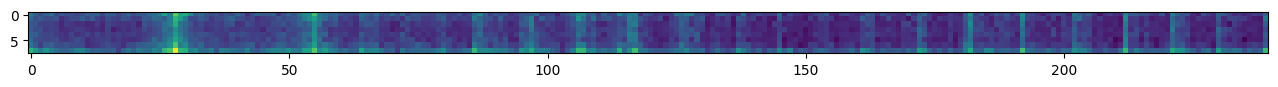

Field,Size,Data
data,"(240, 73, 100, 8)",7ef8f1 (hash)
diode,"(240, 73, 100)",c0f8b3 (hash)
weights,"(240, 73, 100, 8)",6181af (hash)
Number of pixels j,1,73
Number of pixels k,1,100


In [56]:
plt.figure(figsize=(16, 6))
plt.imshow(data_container.projections.data[:, 0, 20].T)
plt.show()
data_container.projections

/Users/lfbarba/GitHub/smartTT/.venv/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],
/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/3734390562.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


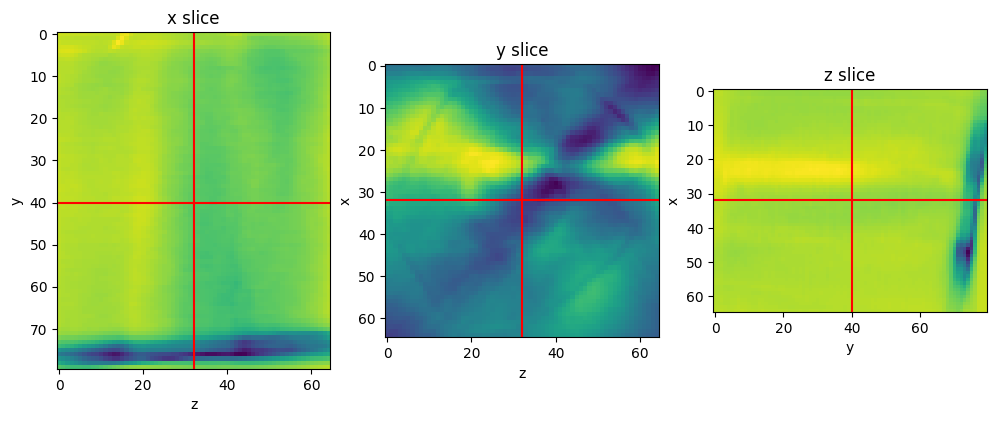

In [57]:
result = residual_calculator.get_residuals(get_gradient = True)

fig, axs = plot_scalar_slices(result['gradient'][..., 12])
fig.show()

Now the loss function.

In [58]:
from mumott.optimization.loss_functions import SquaredLoss, HuberLoss
loss_function = SquaredLoss(residual_calculator, use_weights = True)

$\mu \lVert\matrix{D}\vec{c} \rVert_{b}$ is a regularization term. This can be added if your reconstructions look bad.  

Now we are ready to perform the optimization.

In [59]:
from mumott.optimization.optimizers import LBFGS
from scipy.optimize import Bounds
bounds = Bounds(lb = 0)

optimizer = LBFGS(loss_function, maxiter=10)
results = optimizer.optimize()

100%|██████████| 10/10 [01:32<00:00,  9.25s/it]


/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/2306394593.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


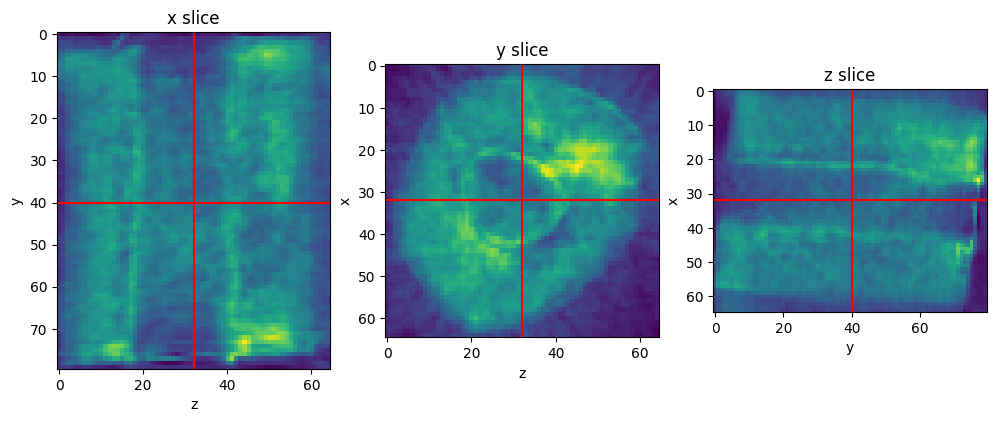

In [60]:
fig, axs = plot_scalar_slices(results['x'][..., 0])
fig.show()

### 7 Plots of reconstruction results

The fancy 3D plots with shiny spheres that you are used to seeing in publication,  
we use other pieces of software to generate. But when we are working with the  
reconstructions, we need to be able to plot some other simple thing.

I will cover 3 different types of plots:

1. Synthetic data colorful plots
2. 2D RSMs of single voxels
3. Direction of slices as colour

First synthitic data:


In [61]:
synthetic_data = basis_set.forward(projector.forward(results['x']))

/Users/lfbarba/GitHub/smartTT/blue_amazon_frog/python_scripts/mumott_plotting/data_plots.py:56: RuntimeWarning: invalid value encountered in divide
  rgb = SSAXS_color(angles, a1/a0, a0, max_doo, max_intens)
/var/folders/tz/dk16058s17q23bj28chlys680000gn/T/ipykernel_40754/1734263639.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/lfbarba/GitHub/smartTT/.venv/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


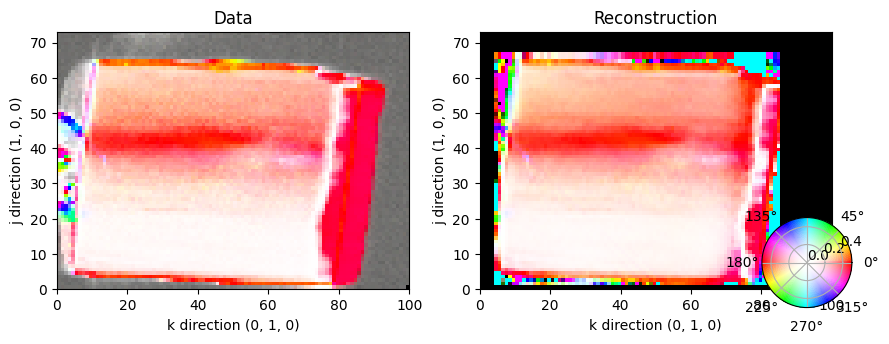

In [62]:

p_index = 0

fig, axs = plt.subplots(1,2, figsize = (10, 6))
img, rgb = make_colorful_plot(data_container.data[p_index, ...], data_container.geometry, axs[0], max_intens = max_intens, max_doo = max_doo)
axs[0].set_title('Data')

img, rgb = make_colorful_plot(synthetic_data[p_index, ...], data_container.geometry, axs[1], max_intens = max_intens, max_doo = max_doo)
axs[1].set_title('Reconstruction')
ax = fig.add_subplot([0.8, 0.25, 0.15, 0.15], polar = True)
make_color_wheel(ax, max_doo)
fig.show()

RSMs of single voxels. First pick a voxel.

In [68]:
example_voxel = (20, 40, 15)

plot_scalar_slices(results['x'][..., 0], example_voxel = example_voxel)


TypeError: plot_scalar_slices() got an unexpected keyword argument 'example_voxel'

In [64]:
coefficients = results['x'][example_voxel[0], example_voxel[1], example_voxel[2], :]

/Users/lfbarba/GitHub/smartTT/.venv/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],
/Users/lfbarba/GitHub/smartTT/.venv/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


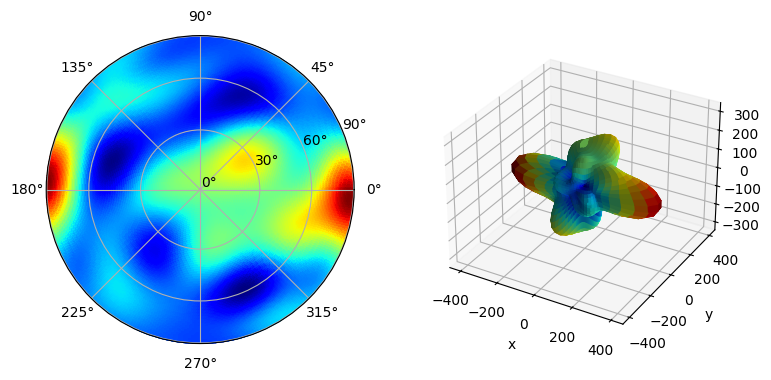

In [67]:
fig = plt.figure(figsize = (9,4)) 
ax = plt.subplot(1,2,1, polar = True)
map_intensity, map_theta, map_phi = basis_set.generate_map(coefficients, map_half_sphere = True, resolution_in_degrees = 1)
plot_on_polefigure(ax, map_intensity, map_theta, map_phi)

map_intensity, map_theta, map_phi = basis_set.generate_map(coefficients, map_half_sphere = False, resolution_in_degrees = 5)
ax = plt.subplot(1,2,2, projection='3d')
surface = make_scattering_vector_plot(ax, map_intensity, map_theta, map_phi)
plt.show()

For the last step, we want to first compute the "main orientation" for
each voxel. mumott provides a funtion for this:

In [ ]:
output = basis_set.get_output(results['x'])

print(output['spherical_functions'].keys())

main_direction = output['spherical_functions']['eigenvectors'][...,0]

dict_keys(['means', 'variances', 'eigenvectors', 'r2_tensors', 'tensor_to_matrix_indices', 'eigenvalues', 'main_orientations', 'main_orientation_symmetries', 'normalized_standard_deviations', 'power_spectra', 'power_spectra_ell'])


(<Figure size 1200x500 with 3 Axes>,
 array([<Axes: title={'center': 'x slice'}, xlabel='z', ylabel='y'>,
        <Axes: title={'center': 'y slice'}, xlabel='z', ylabel='x'>,
        <Axes: title={'center': 'z slice'}, xlabel='y', ylabel='x'>],
       dtype=object))

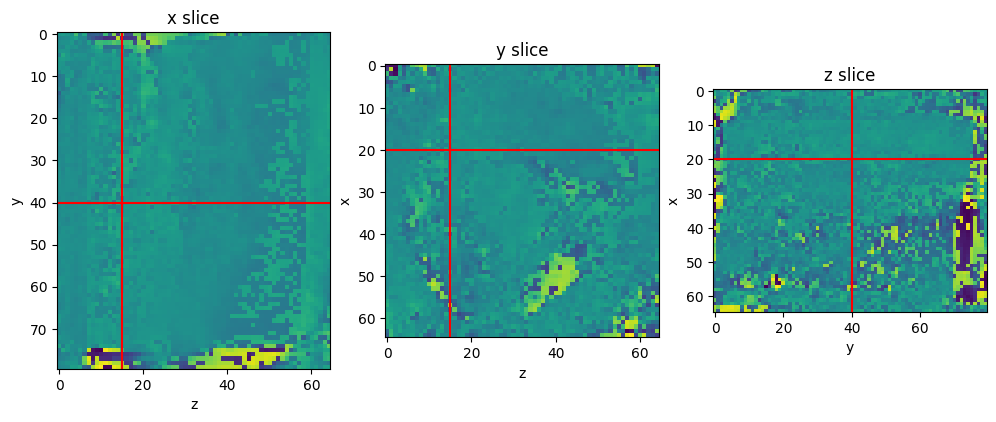

In [ ]:
plot_scalar_slices(main_direction[..., 0], example_voxel = example_voxel)

In [ ]:

def direction_rgb(theta, phi):
    


def plot_direction_in_slice(main_direction, slice_index, slice_orientation = 'xy'):
    
    # take care of flipping logic 
    if slice_orientation == 'xy':
        direction_in_slice = main_direction[:, :, slice_index, :]
        where_flip = direction_in_slice[..., 2] < 0.0
        direction_in_slice[where_flip, :] = -direction_in_slice[where_flip, :]
        direction_in_slice = np.transpose((1,0,2))
        theta = np.arccos(direction_in_slice[..., 2])
        phi = np.arctan2(direction_in_slice[..., 1], direction_in_slice[..., 0])
    elif slice_orientation == 'yx':
        direction_in_slice = main_direction[:, :, slice_index, :]
        where_flip = direction_in_slice[..., 2] < 0.0
        direction_in_slice[where_flip, :] = -direction_in_slice[where_flip, :]
        theta = np.arccos(direction_in_slice[..., 2])
        phi = np.arctan2(direction_in_slice[..., 0], direction_in_slice[..., 1])
    elif slice_orientation == 'xz':
        direction_in_slice = main_direction[:, slice_index, :, :]
        where_flip = direction_in_slice[..., 1] < 0.0
        direction_in_slice[where_flip, :] = -direction_in_slice[where_flip, :]
        direction_in_slice = np.transpose((1,0,2))
        theta = np.arccos(direction_in_slice[..., 1])
        phi = np.arctan2(direction_in_slice[..., 2], direction_in_slice[..., 0])
    elif slice_orientation == 'zx':
        direction_in_slice = main_direction[:, slice_index, :, :]
        where_flip = direction_in_slice[..., 1] < 0.0
        direction_in_slice[where_flip, :] = -direction_in_slice[where_flip, :]
        theta = np.arccos(direction_in_slice[..., 1])
        phi = np.arctan2(direction_in_slice[..., 0], direction_in_slice[..., 2])   
    elif slice_orientation == 'yz':
        direction_in_slice = main_direction[slice_index, :, :, :]
        where_flip = direction_in_slice[..., 0] < 0.0
        direction_in_slice[where_flip, :] = -direction_in_slice[where_flip, :]
        direction_in_slice = np.transpose((1,0,2))
        theta = np.arccos(direction_in_slice[..., 0])
        phi = np.arctan2(direction_in_slice[..., 2], direction_in_slice[..., 1])     
    elif slice_orientation == 'zy':
        direction_in_slice = main_direction[slice_index, :, :, :]
        where_flip = direction_in_slice[..., 0] < 0.0
        direction_in_slice[where_flip, :] = -direction_in_slice[where_flip, :]
        theta = np.arccos(direction_in_slice[..., 0])
        phi = np.arctan2(direction_in_slice[..., 1], direction_in_slice[..., 2])     
        
        
    